In [ ]:
# Colab code
# Mount data
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Colab code 
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Not connected to a GPU')
# else:
#   print(gpu_info)

Thu Aug  8 00:45:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0              55W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
# Colab code: Install packages
# !pip install umap-learn bertopic hdbscan scikit-learn

In [60]:
# Load Json data:

# file_path = '/content/drive/MyDrive/combined.jsonl' # in Colab

import os
file_path = r'C:\Users\hoath\Git\LobbyMap_ML\data\processed\combined.jsonl'


# Load JSONL data
data = []
with open(file_path, 'r') as file:
    for line in file:
        data.append(json.loads(line))

df = pd.DataFrame(data)

print(df.iloc[0])


document_id    -000-985-AES_nytimes_CEOnuclear_15.6.22_june20...
sentences      [{'sentence_id': 0, 'page_idx': 0, 'block_idx'...
evidences      [{'query': 'alignment_with_ipcc_on_climate_act...
meta           {'parser': 'fitz', 'evidences': [[{'company_na...
Name: 0, dtype: object


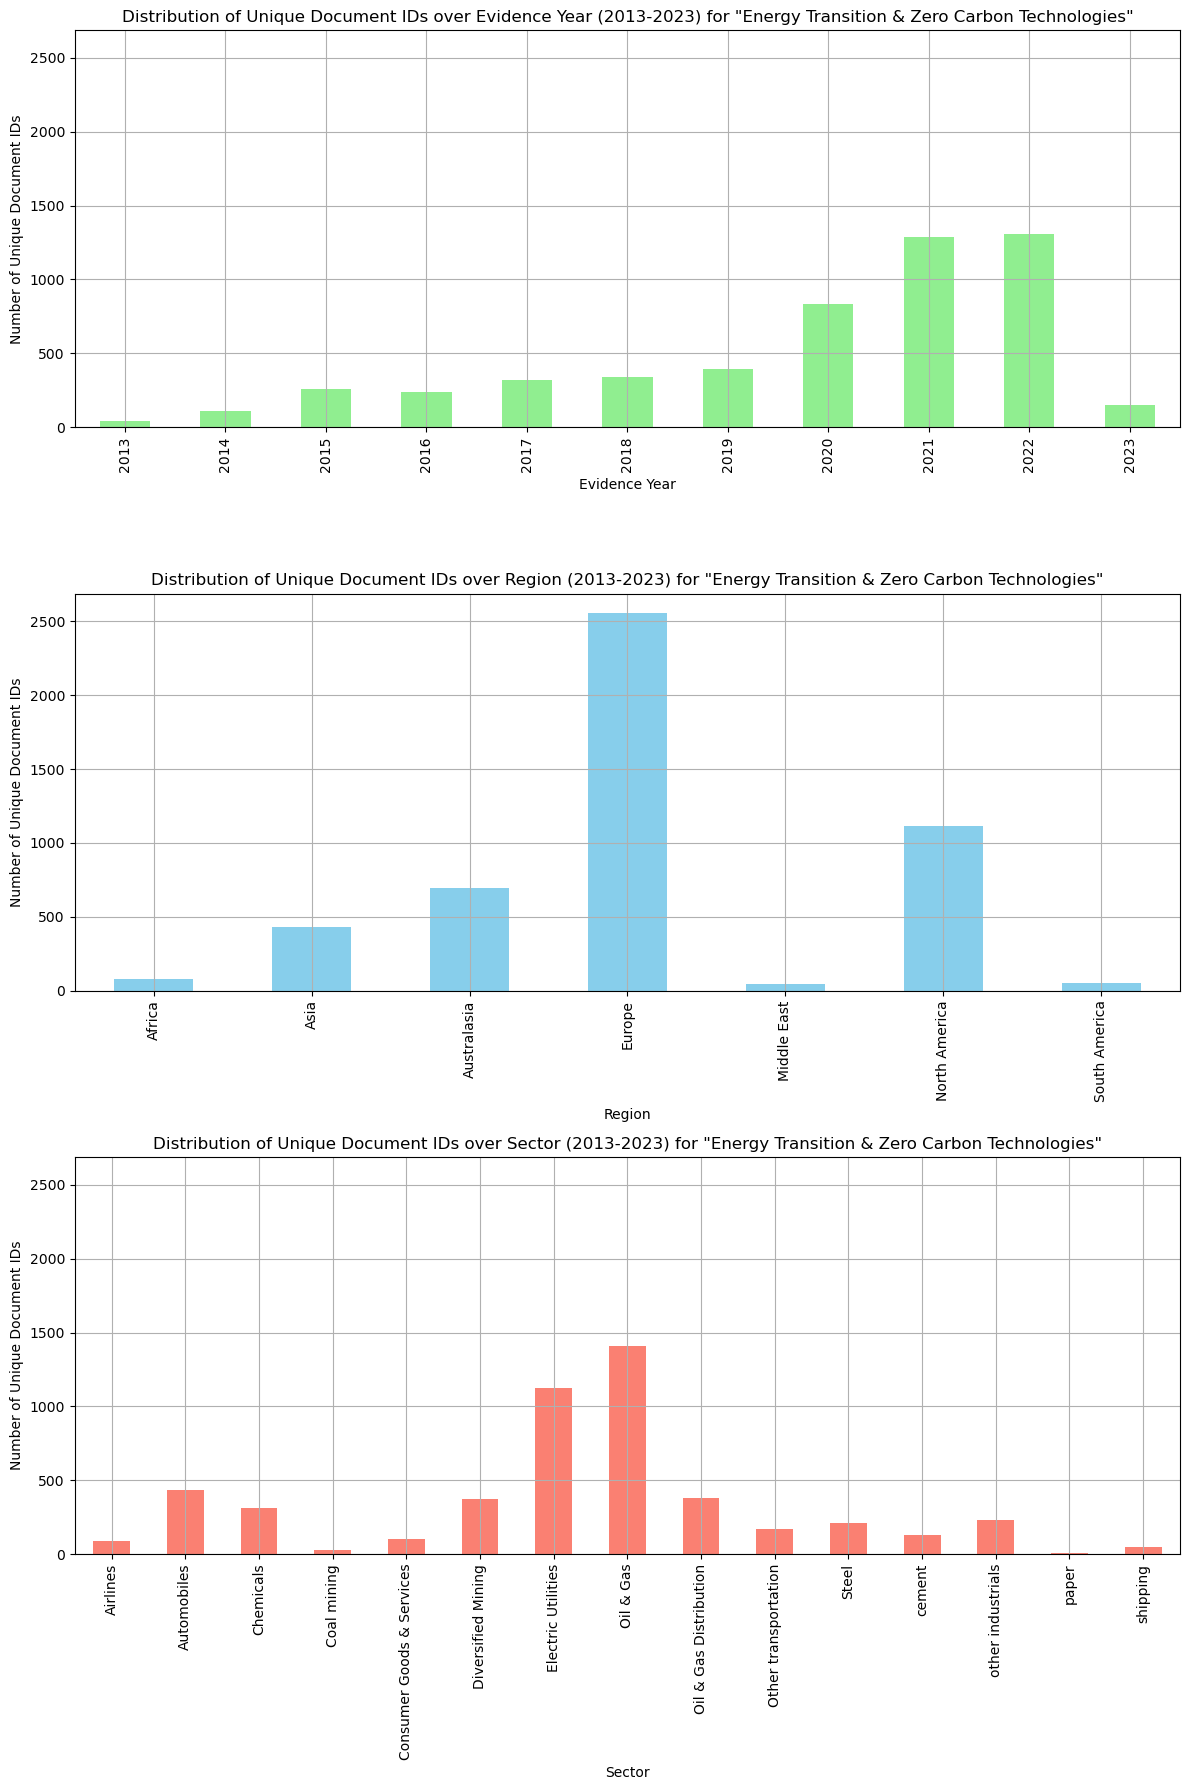

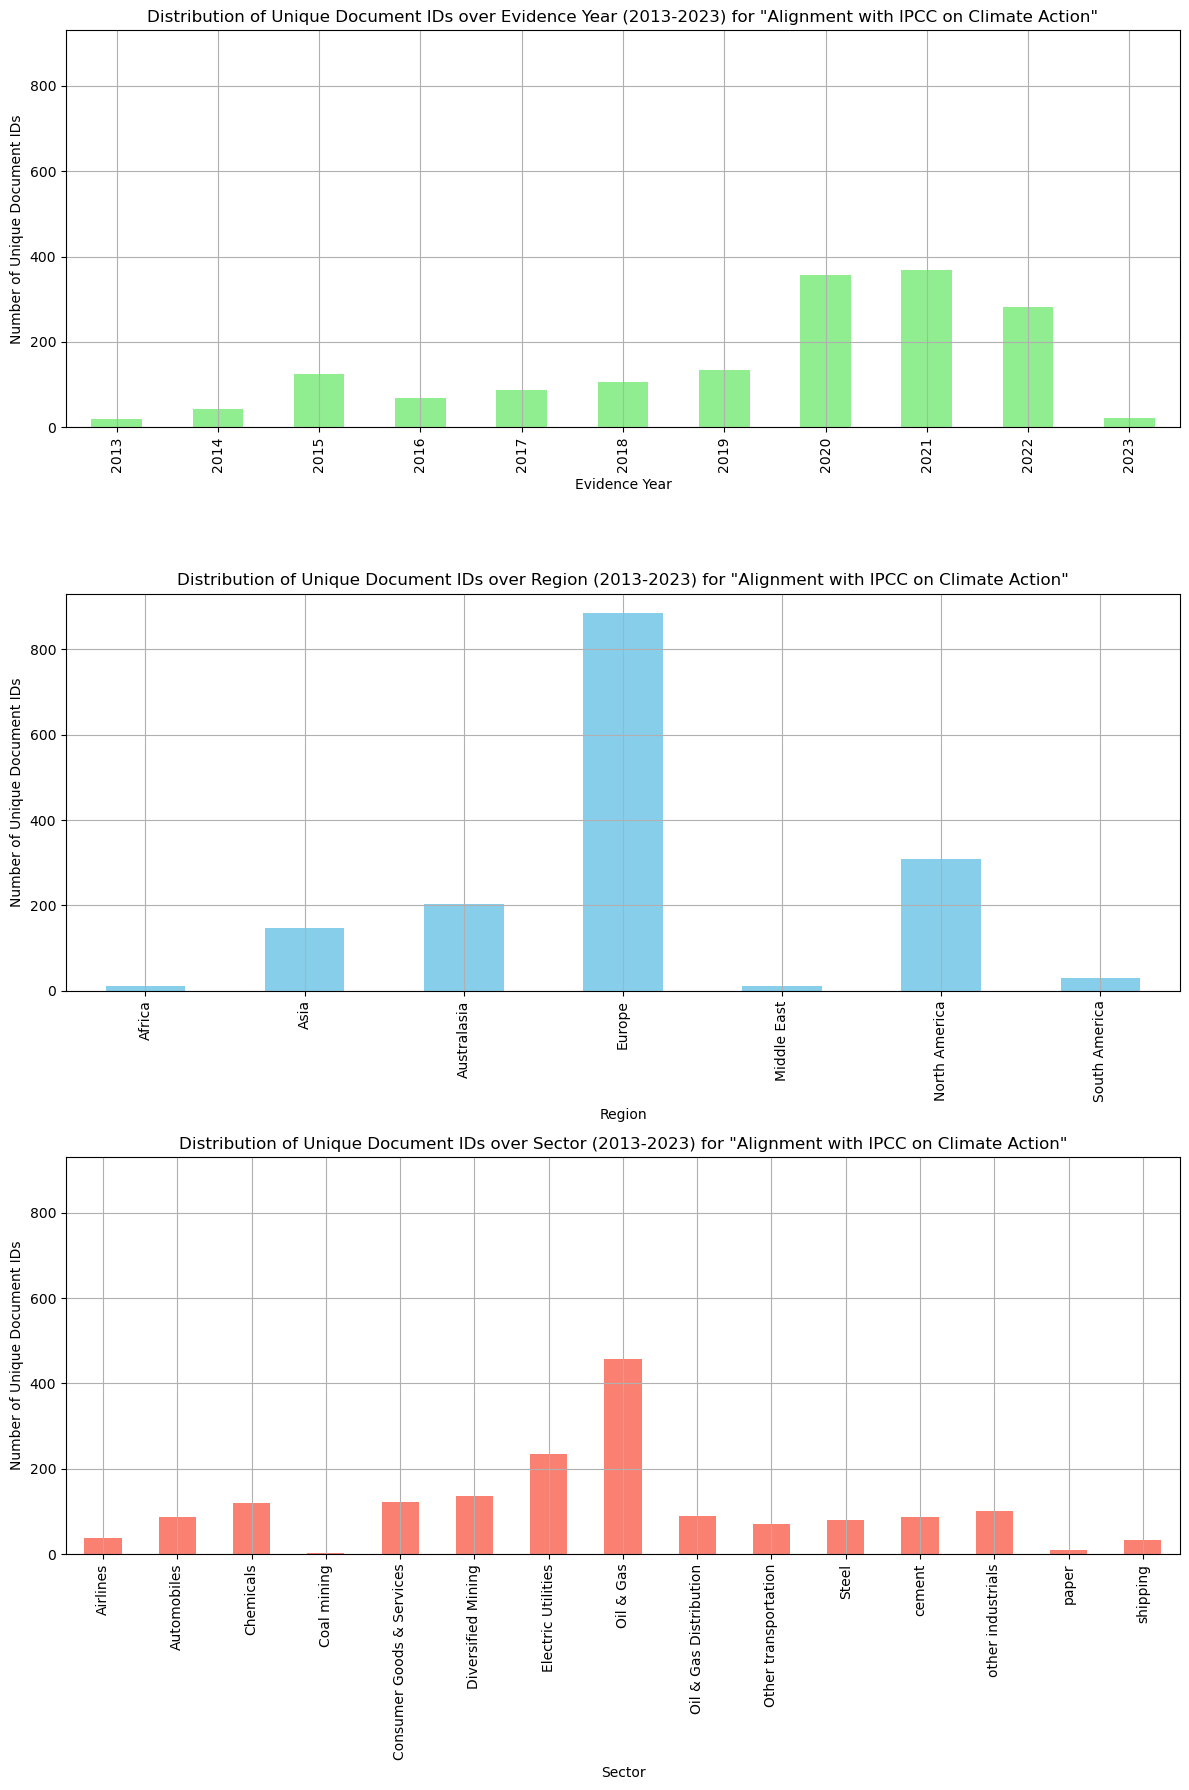

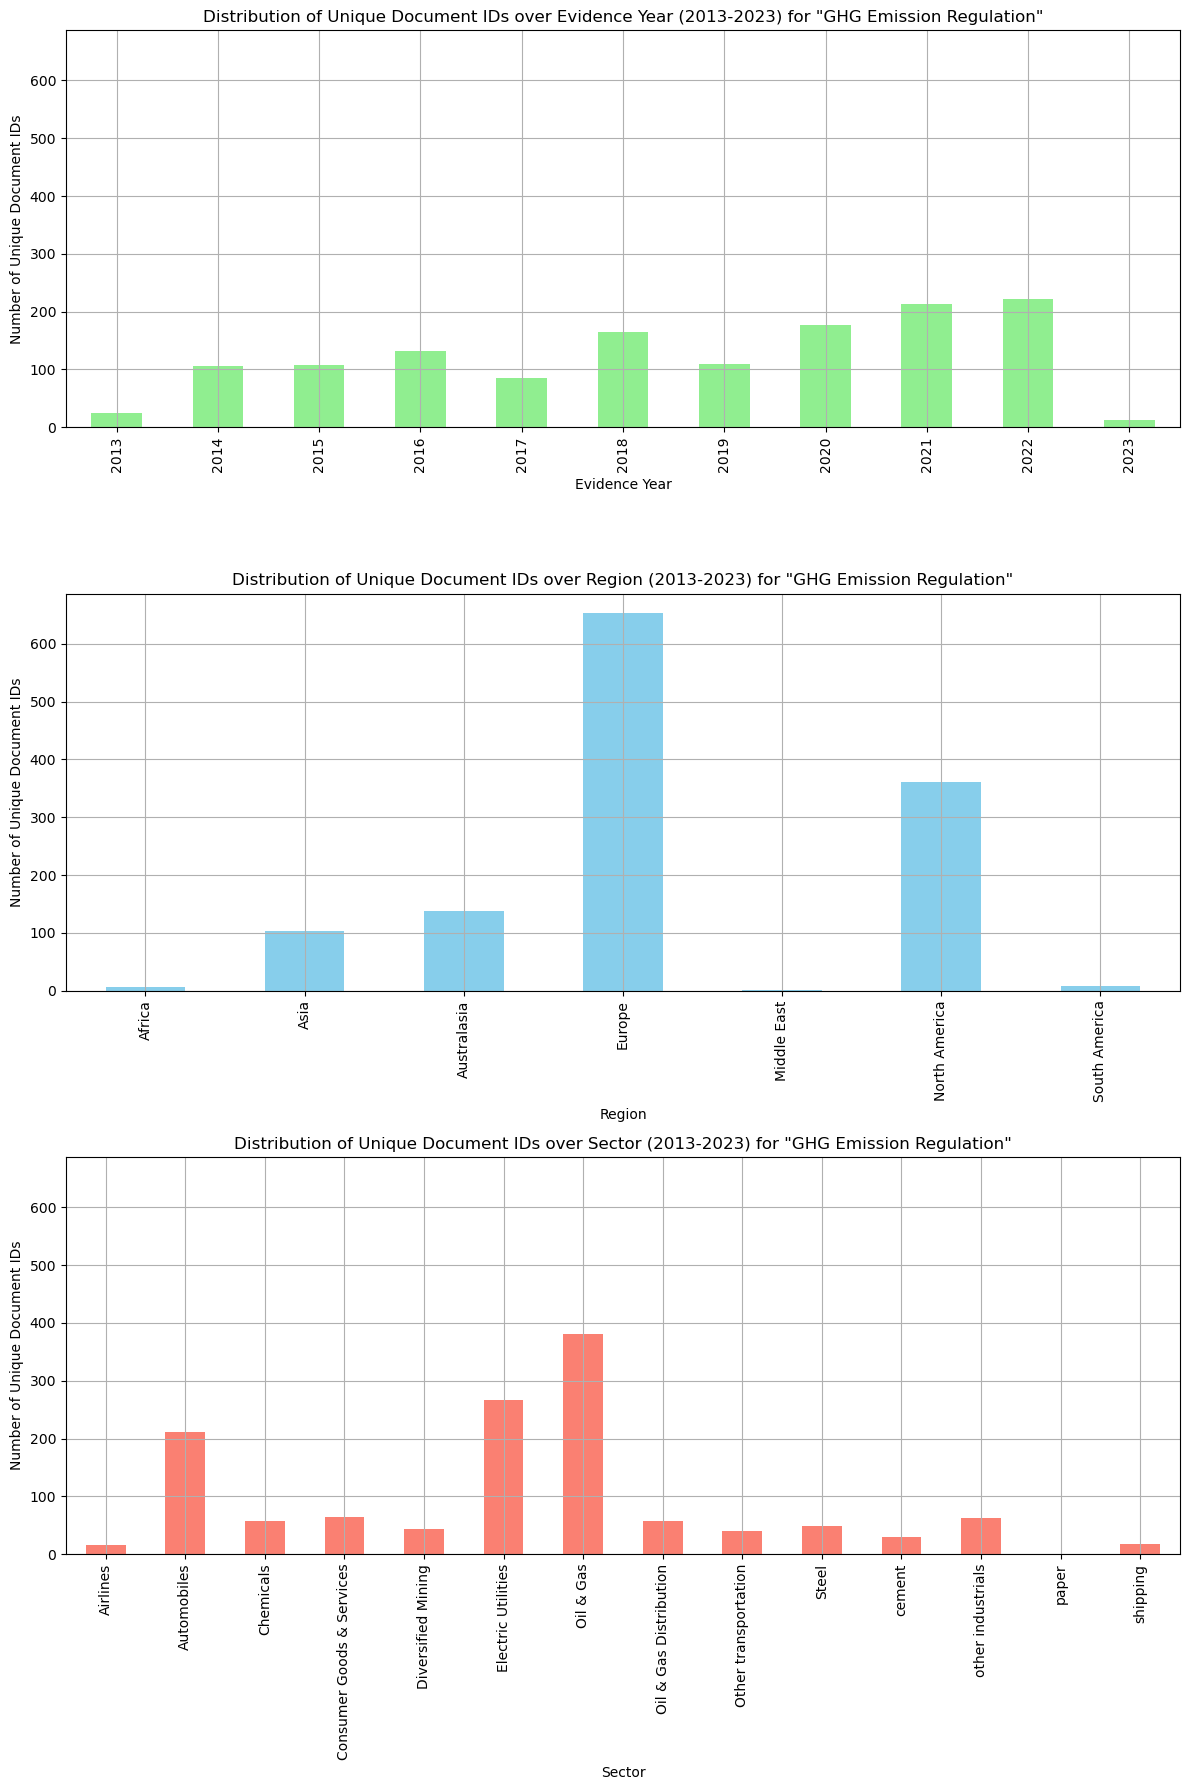

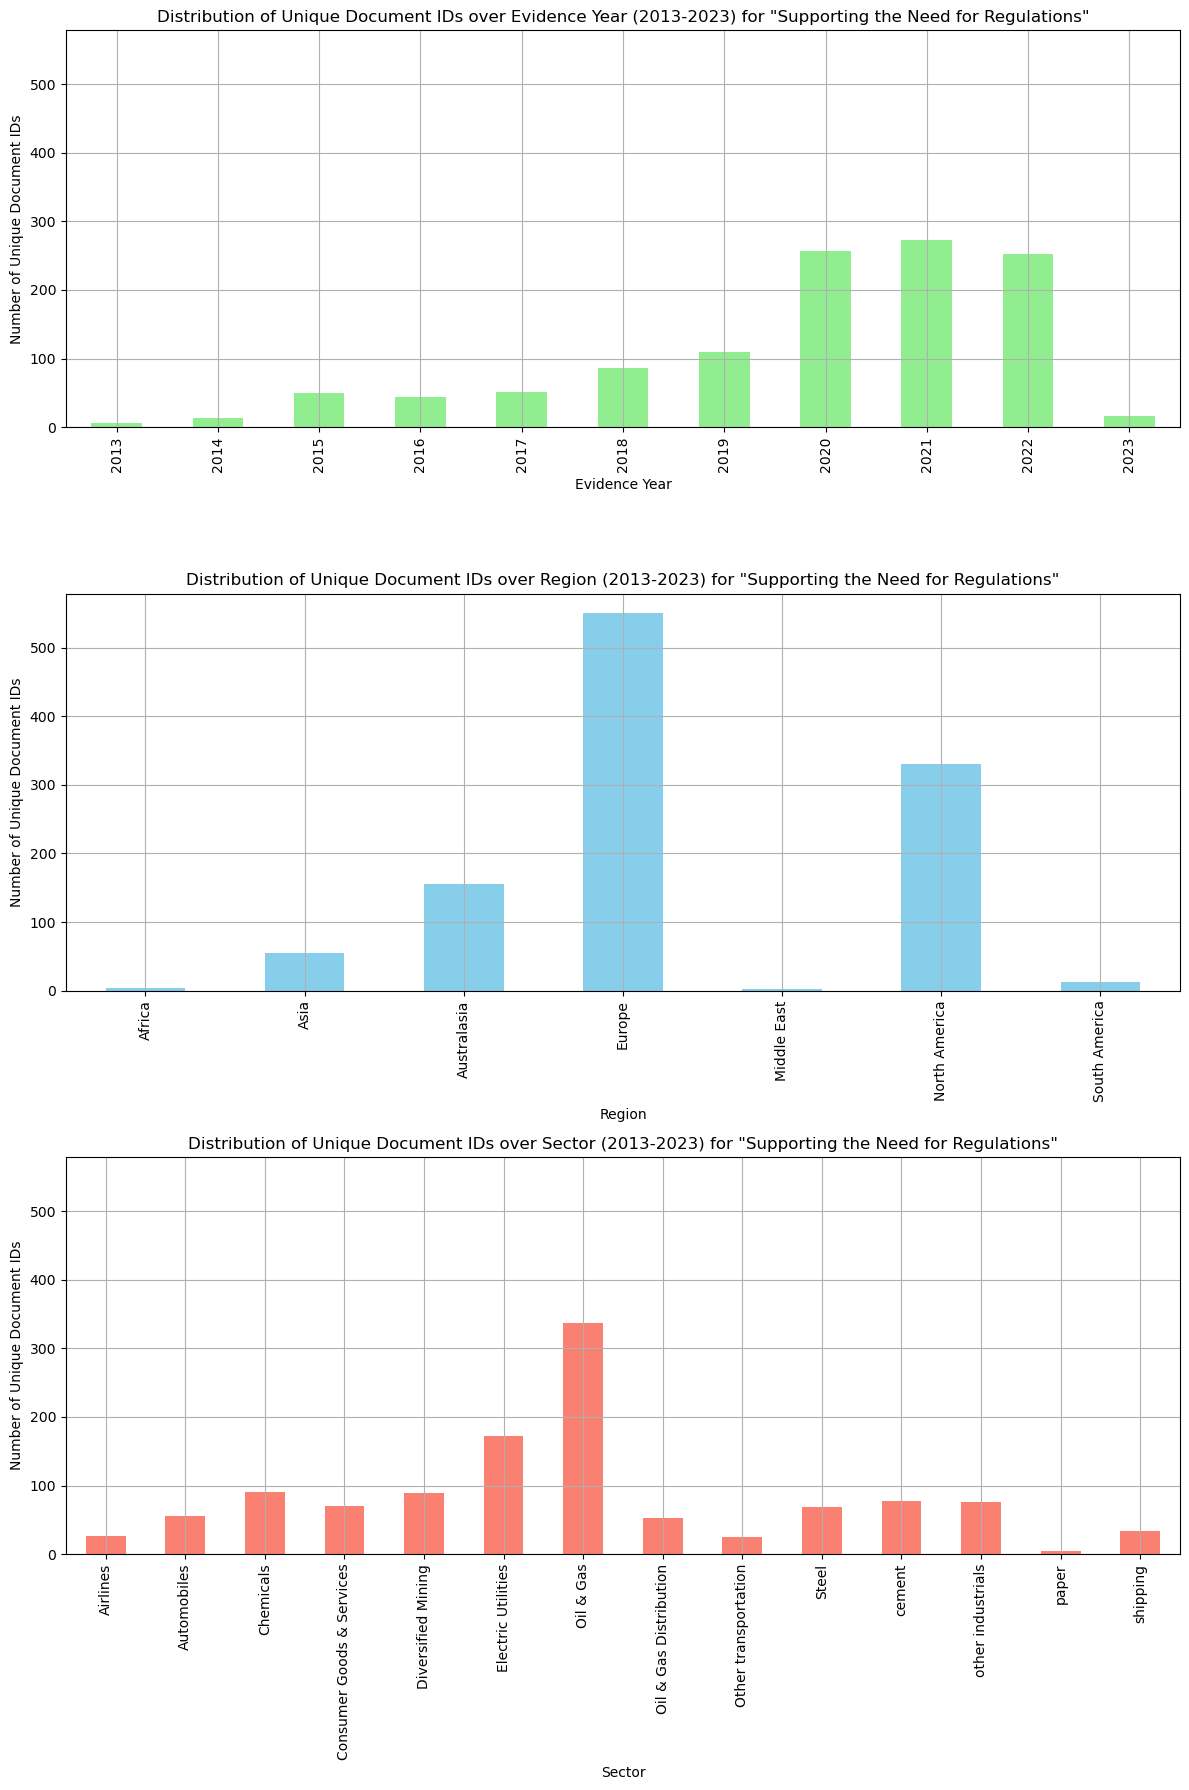

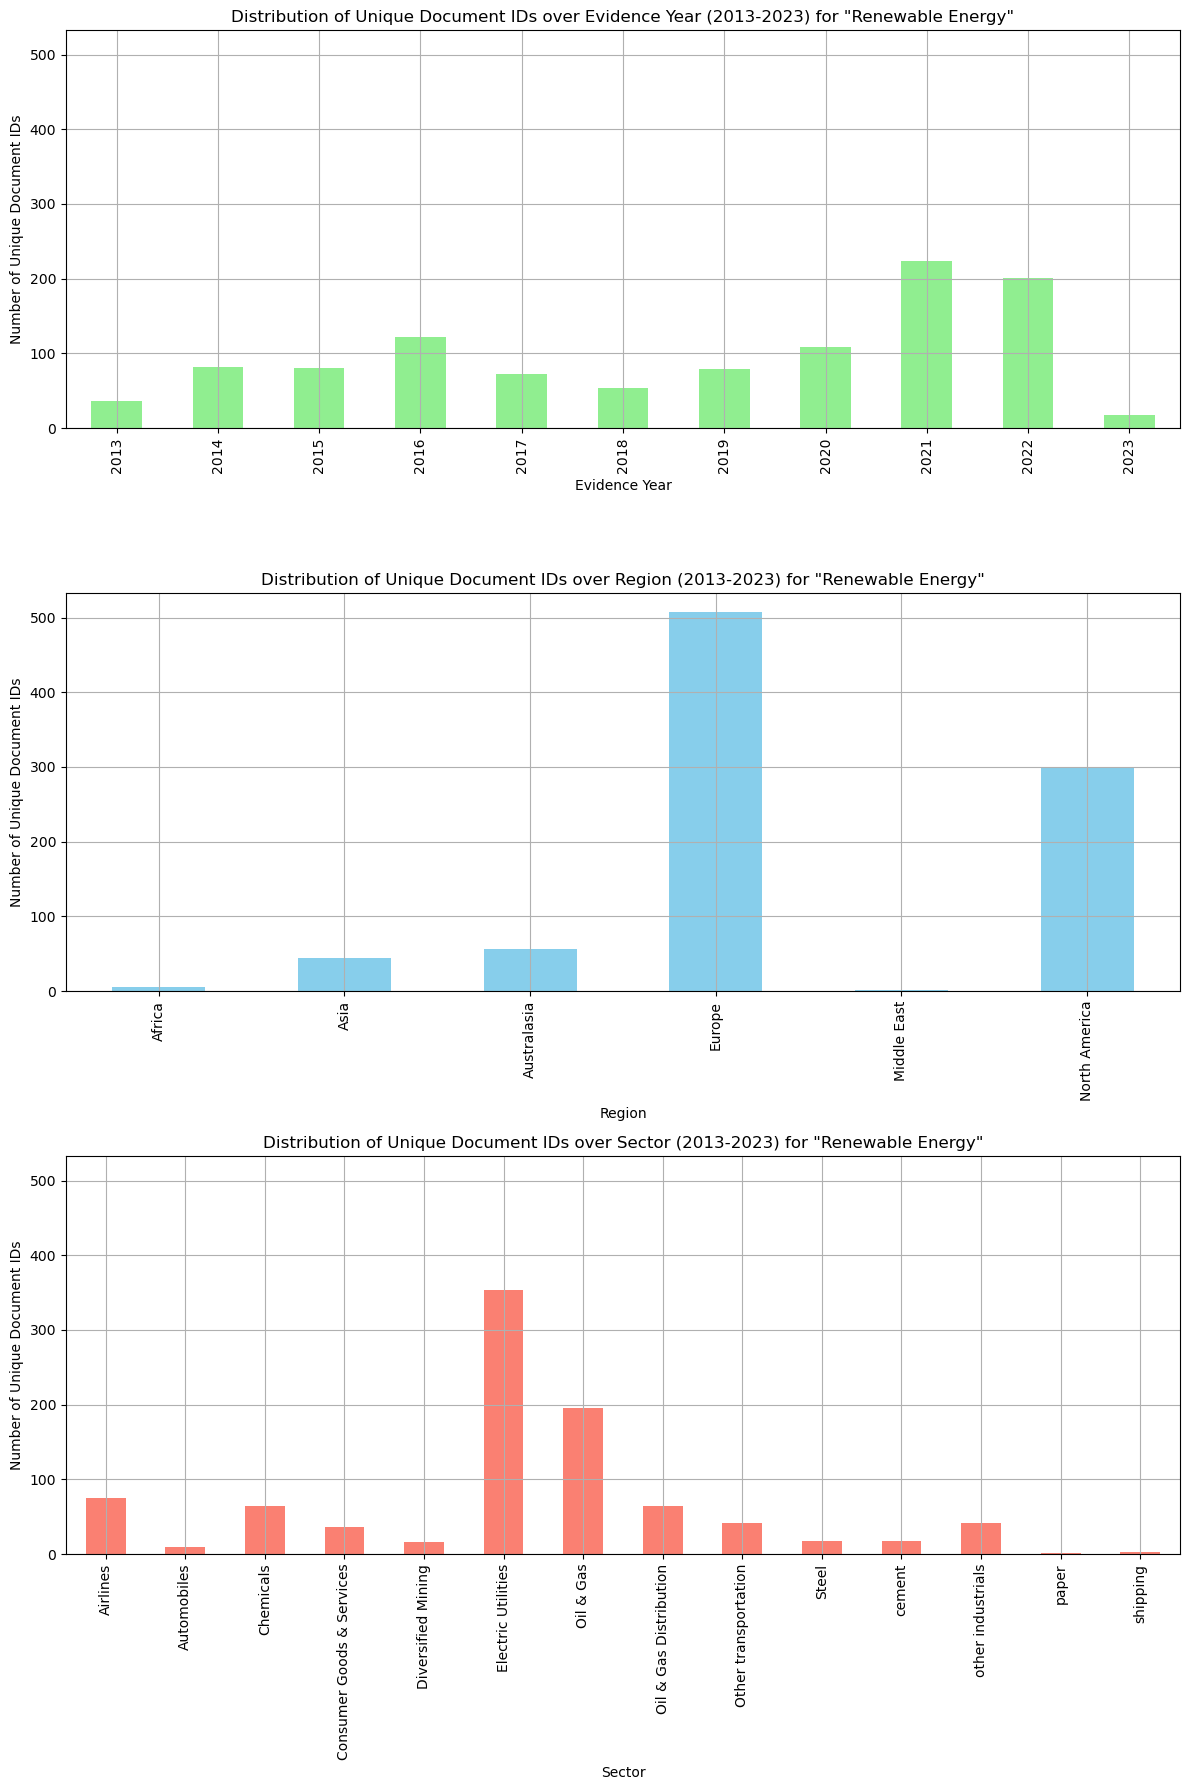

In [61]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# File paths
jsonl_file_path = r'C:\Users\hoath\Git\LobbyMap_ML\data\processed\combined.jsonl'
csv_file_path = r'C:\Users\hoath\Git\LobbyMap_ML\data\processed\company_sector_region.csv'

# Load the company sector and region data
company_info = pd.read_csv(csv_file_path)

# List of evidence queries to filter
evidence_queries = ["Energy Transition & Zero Carbon Technologies", "Alignment with IPCC on Climate Action",  "GHG Emission Regulation",
                     "Supporting the Need for Regulations", "Renewable Energy"]

# Initialize a dictionary to collect data for all evidence queries
all_data = defaultdict(lambda: defaultdict(list))

# Read the JSONL file and extract necessary fields
with open(jsonl_file_path, 'r', encoding='utf-8') as file:
    for line in file:
        entry = json.loads(line)
        document_id = entry.get('document_id')
        
        # Iterate through the list of evidences
        for evidence in entry.get('meta', {}).get('evidences', []):
            # Handle both list and dictionary cases
            if isinstance(evidence, list):
                for sub_evidence in evidence:
                    company_name = sub_evidence.get('company_name')
                    evidence_year = sub_evidence.get('evidence_year')
                    evidence_query = sub_evidence.get('evidence_query')
                    
                    # Filter by evidence_query list and year range
                    if company_name and evidence_query in evidence_queries and 2013 <= evidence_year <= 2023:
                        all_data[evidence_query]['evidence_years'].append(evidence_year)
                        all_data[evidence_query]['document_ids'].append(document_id)
                        all_data[evidence_query]['company_names'].append(company_name)
            elif isinstance(evidence, dict):
                company_name = evidence.get('company_name')
                evidence_year = evidence.get('evidence_year')
                evidence_query = evidence.get('evidence_query')
                
                # Filter by evidence_query list and year range
                if company_name and evidence_query in evidence_queries and 2013 <= evidence_year <= 2023:
                    all_data[evidence_query]['evidence_years'].append(evidence_year)
                    all_data[evidence_query]['document_ids'].append(document_id)
                    all_data[evidence_query]['company_names'].append(company_name)

# Loop through each evidence_query and create plots
for target_evidence_query in evidence_queries:
    # Check if there is data for the current evidence_query
    if all_data[target_evidence_query]['company_names']:
        # Convert the dictionary to a DataFrame
        df_json = pd.DataFrame(all_data[target_evidence_query])

        # Merge with the company sector and region information
        merged_df = pd.merge(df_json, company_info, left_on='company_names', right_on='company_name', how='left')

        # Prepare data for each bar chart
        region_grouped = merged_df.groupby('region')['document_ids'].nunique()
        sector_grouped = merged_df.groupby('sector')['document_ids'].nunique()
        year_grouped = merged_df.groupby('evidence_years')['document_ids'].nunique()

        # Set up the combined figure with subplots
        fig, axs = plt.subplots(3, 1, figsize=(12, 18), sharey=True)

        # Plot for Evidence Year Distribution
        year_grouped.plot(kind='bar', color='lightgreen', ax=axs[0])
        axs[0].set_title(f'Distribution of Unique Document IDs over Evidence Year (2013-2023) for "{target_evidence_query}"')
        axs[0].set_xlabel('Evidence Year')
        axs[0].set_ylabel('Number of Unique Document IDs')
        axs[0].grid(True)

        # Plot for Region Distribution
        region_grouped.plot(kind='bar', color='skyblue', ax=axs[1])
        axs[1].set_title(f'Distribution of Unique Document IDs over Region (2013-2023) for "{target_evidence_query}"')
        axs[1].set_xlabel('Region')
        axs[1].set_ylabel('Number of Unique Document IDs')
        axs[1].grid(True)

        # Plot for Sector Distribution
        sector_grouped.plot(kind='bar', color='salmon', ax=axs[2])
        axs[2].set_title(f'Distribution of Unique Document IDs over Sector (2013-2023) for "{target_evidence_query}"')
        axs[2].set_xlabel('Sector')
        axs[2].set_ylabel('Number of Unique Document IDs')
        axs[2].grid(True)

        # Adjust layout
        plt.tight_layout()

        # Show the combined plot
        plt.show()
    else:
        print(f"No data available for '{target_evidence_query}'.")
